Prix de l’option: 2.3276007021349323
Black-Scholes Price: 5.6034


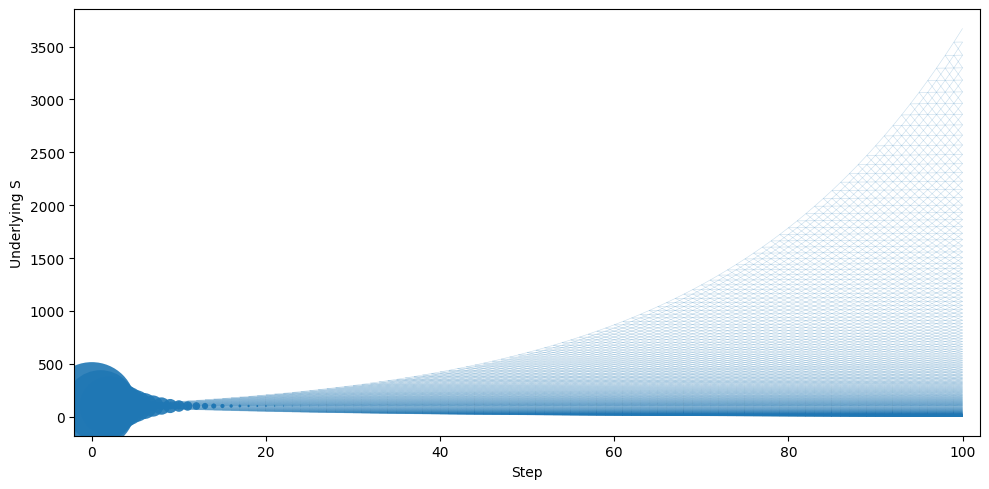

In [3]:
# debut du div, americain, avancer sur convergence

from pricing import BlackScholesPricer, TrinomialTree, Market, Option
from pricing import convergence
from pricing import graphique
import datetime as dt
import sys

sys.setrecursionlimit(100000)
market = Market(S0=100, r=0.03, sigma=0.2, dividend=0, dividend_date=dt.datetime(2026, 7, 30))
option = Option(K=110, option_type="call", maturity=dt.datetime(2026, 10, 30), option_class="european")
tree = TrinomialTree(market, option, N= 100)

price = tree.price()
print("Prix de l’option:", price)

bs_price = BlackScholesPricer().price(S=market.S0, K=option.K, T=tree.delta_t*tree.N, r=market.r, q=0, sigma=market.sigma, option_type='call') # q=0 car pas de dividendes
print("Black-Scholes Price: {:.4f}".format(bs_price))

graphique.plot_tree(tree.root)
# convergence.bs_convergence_by_strike(market, option, [80, 90, 100, 110, 120, 130, 140, 150, 160], N=100)

# convergence.bs_convergence_by_step(market, option, bs_price, max_n = 1000, step = 20)

In [ ]:
# soutenance sur teams de 30 min
# 2 quizz jusqu'à 17h le 29/10 : un qualitatif -> questions et un quantitatif où on va 
# devoir utiliser notre code pour répondre (possible de faire un ajout de code aussi)
# exemple qualitatif : quelle est le plus gros reproche de l'abre trinomial

pricer backward :
- calcul avec une boucle for sans limite de récursion
- on commence les calculs par le noeud de la fi
- allez à la fin avec les truncs nodes
- on calcul la valeur intrinsèque dans la dernière colonne
- on va ajouter le fait de revenir un cran en arrière sur le noeud tronc
- on peut avoir une classe TruncNode qui dérive de Node
- il faut aussi que n'importe quelle noeud de la colonne connaisse son TruncNode
- ensuite on remonte noeud par noeud et utilise la même fonction price que le récursif (la même forme)

problème des probas pas dans 0, 1:
il faut que le noeud mid soit le plus proche de l'espérance --> il faut changer de noeud mid quand ça dépasse 1 ou en dessous de 0
il va falloir attribuer next_mid en cherchant autour
lui sa construction il l'a fait en montant petit à petit dans les deux colonnes t et t+1 en même temps
tant que le next_mid est entre le next_mid actuel et la moyenne entre next_mid et next_up alors on garde ce next_mid sinon on attribue next_mid comme étant next_up, attribuer next_mid au noeud le plus proche de l'espérance --> calculer la moyenne entre le deux noeuds possible
le problème vient des noeuds du bas avec des valeur négative quand on soustrait le div--> résolu par le pruning qui enlève beaucoup de noeuds du bas

il faudrait que la colonne t sache que la colonne t+1 reçoit le dividende

REGARDER LES GRAPHS LOG LOG AVANT DE FAIRE LE PRUNING

Pruning : 
- soit proba d'arriver au noeud
- soit nombre d'écart type de S avec le trunc node (4 écarts types)
- chaque noeud à sa proba
- chaque noeud vient peut être de 3 noeud, à chaque fois qu'on fait une liaison vers ce noeud on rajoute à la proba cumulé du noeud vers lequel on va la contribution du noeud parent : next_down.proba_cumulée = next_down.proba_cumulée + current_node.proba ---> méthode dans Node
quand on monte dans l'arbre et que c'est trop petit, on fait juste un next_mid avec une proba de 1 ---> monomial ---> tant que c'est trop petit ---> monomial
le noeud qui a une proba faible crée un noeud monomial ! il existe mais ne crée pas plusieurs noeud c'est tout
- autre méthode = écart type